## MountainCar with Q-learning, example 1

#### The goal: The car should only cross the flag pole on top of the mountain (with Q-learning)

In [1]:
# usual imports
import gymnasium as gym
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

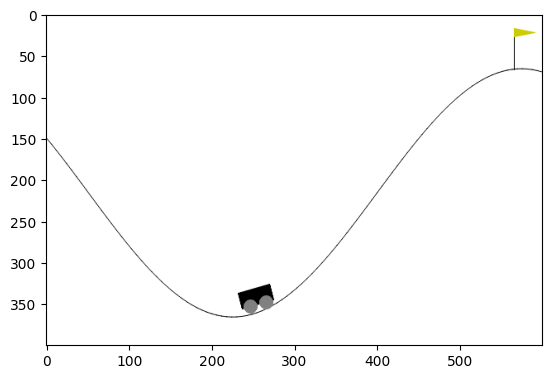

In [2]:
# make the env
env = gym.make("MountainCar-v0", render_mode='rgb_array')

# visualize the environment
env.reset()
plt.imshow(env.render())

In [3]:
# observation space
# the position is between -1.2 to 0.6
# the velocity is between -0.07 to 0.07
# from previous experiments, the goal/flag is in position 0.5 exactly
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

### Let's create the bins for position and velocity

In [4]:

# I have changed num_bins = 50 to 60 and elocity_bins = 30 to 40. This means Before: 50 × 30 = 1,500 states and After: 60 × 40 = 2,400 states
# In result by changing these paratmeters 60% increase in state space size.
# With this approach what is improved by this changing values (Also I played around with these value and done different experiments on it)
# Higher Resolution of the Environment
# The agent can differentiate more precise positions and speeds
# Better chance to learn nuanced strategies (like when to push vs. coast in terms of Memory Utilization etc)
# Improved Policy Quality
# Especially in tricky regions (like approaching the hill’s peak), more bins help fine-tune decisions
# what Setbacks noticed with this approach (Obviously also its a concultion of different experiments)
# Increased Memory Usage
# Q-table becomes significantly larger (more states = more entries)
# Slower Learning
# With more states, the agent needs more episodes to visit enough of them and learn an effective policy
# Exploration Risk
# It might not tuned well (epsilon decay, etc.), many of the new states may never be visited
# but yes with this approach some points are still remain same, like actions time stamps , physics and rewards, actions are unchanged.



In [5]:
# Parameters Changed learning_rate = 0.08 (was 0.1) and decay_rate = 0.0008 (was 0.001)
# how much the Q-value is updated each time a new reward is received , if low learning rate this mean smaller updates.
# how epsilon (exploration rate) decays over time. Lower value means exploration lasts longer 

# I have noticed these improvements 
# More stable learning — less likely to good values and Better exploration early on — can find better long-term strategies

# what is setback that is observed by changing these parameteres
# Slower convergence — may take more episodes to learn and Might waste time exploring when it's already learned a good policy

# By changing these values even there are some points still remain same, there is no impact on that
# No effect if agent doesn't learn well at all (bad reward feedback)


In [ ]:
# Differences with Q-Table and  start Learnings 
# I also added one more visualization so, this discription is based on that, also i printed episodes and rewards as well.
# The agent initially explored randomly and received low rewards (mostly around -200). Over time, as it updated its Q-table and reduced exploration, it started improving its actions. By episode 2638, the moving average of the rewards consistently exceeded the threshold of -110, showing that the agent learned a strategy to reliably reach the goal. After this point, performance stabilized, indicating successful policy learning.

# Q learning Table differences and when agent start learning envoirment well according first and second exercise anaylisis.
# In my previous assignment I noticed Agent starts learning well when first time he founds the gift, As it found the gift and then agent anaylise the values.
# For example, agent look into values, right, left, up and down, where it get good observation value or larger observation value then it move that step or take that action. 
# but I found in this exercise its hard to analysie when agent will start learn envoirment well. I tried to visulize it, and I found when Upword trends 
# The agent began learning the environment well when the episode rewards showed a consistent upward trend, the moving average crossed the threshold (−110), and the reward values became more stable—starting around episode 2638.

# Q-table in first exercise shows focused learning in specific states, typical of environments like FrozenLake with traps and goals.
#Q-table 2 reflects broader, continuous exploration in MountainCar, with more generalized Q-values across the state space.
#FrozenLake uses a small, discrete Q-table with sparse rewards and localized learning, making it easier to visualize. MountainCar has a larger, discretized Q-table from continuous states with dense exploration and generalization across many states.

In [7]:
# helper variables
# you can adjust the amount of bins for better accuracy
# but remember, more bins => heavier agent to train (more memory needed also)
num_position_bins = 60
num_velocity_bins = 40

# for calculating the needed steps in the bins
max_position = env.observation_space.high[0]
min_position = env.observation_space.low[0]
max_velocity = env.observation_space.high[1]
min_velocity = env.observation_space.low[1]

# create the bins for position and velocity separately
# first step, create the ranges between the bins by using LINSPACE
position_bins = np.linspace(min_position, max_position, num_position_bins)
velocity_bins = np.linspace(min_velocity, max_velocity, num_velocity_bins)

In [8]:
# how many states will we have in total, just to check that 
# it's something we'd expect
num_states = num_position_bins * num_velocity_bins
print(f"Number of possible states in Q-table: {num_states}")

Number of possible states in Q-table: 2400


## Let's create the Q-table with the help of our bins

In [9]:
# create the Q-table
Q_table = np.zeros((num_position_bins, num_velocity_bins, env.action_space.n))
Q_table.shape

(60, 40, 3)

### Helper functions: update Q-table etc.

In [10]:
# we have to modify this Q-table update function in order to accomodate 
# both position and velocity
# see how the Q-table was created and how the Q-table update code has been updated
# (the index values have to match in both)
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    # we need to accomodate both position and velocity
    # state[0] = position, state[1] = velocity
    Q[state[0], state[1], action] = Q[state[0], state[1], action] + alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1]]) - Q[state[0], state[1], action])
    return Q

In [11]:
# We need another helper function => environment will give all the observations
# (velocity and positions) in the original format, we have to also discretize them on the go
# in other words, all real values have to be mapped into the bins we have
# (30 for position, 20 for velocity => we have to be able to map any real value into
# the correct bin for both position and velocity)
def get_state(observation):
    position = np.digitize(observation[0], bins=position_bins) - 1
    velocity = np.digitize(observation[1], bins=velocity_bins) - 1
    return position, velocity

### Define our hyperparameters

In [12]:

# I have changed paratmeters and did different experiments on it there below i got best finding over it

# By changing this total_episodes = 5000, I got Faster experimentation but it may lead to underfitting or incomplete learning.
# By changint this parameter (max_steps = 300) Gives the agent more time to reach the goal per episode and it helps with slower learners or environments requiring long-term planning. this is the only reason I am thinking it will start learning quickly and give me better results.

# In this experiment, I reduced the training duration to speed up learning, allowing the agent more steps per episode to better explore the environment. A lower learning rate and gamma helped with stability and short-term gains, while higher initial exploration and faster decay encouraged early discovery of strategies. However, this setup risks converging on suboptimal policies if exploration fades too quickly, and shorter training may lead to underfitting.

# Further experiments like increasing state resolution improves learning precision but raises overfitting risk if training is too short. To reduce this, keep some exploration, extend training, and introduce randomness for generalization.


# total training episodes, in this case, 15000 should do
total_episodes = 15000
# Fewer episodes to reduce training time
#total_episodes = 5000

# this environment is probably solvable in 100-200 steps
max_steps = 200
# Allow more steps per episode
# max_steps = 300

# learning rate => 0.2 (to make milder updates)
# you can experiment probably between 0.1 and 0.5
learning_rate = 0.2
 # Smaller updates to the Q-values
#learning_rate = 0.1

# we want to emphasize long term reward this time
# because we only wish our car to get past the flag, there are not that
# many options on how to solve this environment
gamma = 0.99
# Slightly less emphasis on future rewards
# gamma = 0.95

# exploration parameters
epsilon = 0.9
  # Start with more exploration
#   min_epsilon = 1.0

# upper bound of our epsilon
max_epsilon = 0.9
  #  # Allow 100% exploration at start
#   max_epsilon = 1.0

# this is the lower bound, and our code is not going to decay the epsilon below this
# we can actually disable the whole epsilon in this case in the end
min_epsilon = 0.0
  # Don’t let epsilon go all the way to 0
#   min_epsilon = 0.1

# let's ramp up the decay rate for faster switch to using the
# Q-table instead of guessing too much
decay_rate = 0.003
 # Faster epsilon decay (less exploration sooner)
#decay_rate = 0.01

## The training loop (Q-learning)

In [13]:
# for visualizing our reward progress while training
rewards = []

# "play" the game for the amount episodes defined
for episode in range(total_episodes):
    # get initial state
    state, info = env.reset()

    # every time you handle any kind of state (current, old, new)
    # you have to discretize it with your functions
    state = get_state(state)

    # in the beginning of the game, the game is not over
    # the game is done either by falling into a hole or finding the goal
    done = False

    # in the beginning of the game, our total_rewards are 0
    total_rewards = 0

    # start playing the game in this episode
    for step in range(max_steps):

        # PHASE 1: exploration/exploitation
        if np.random.uniform(0, 1) > epsilon:
            # use exploitation in this case => use best known action for this cell!
            # fix this to use correct format
            action = np.argmax(Q_table[state[0], state[1]])
        else:
            # let's explore => random action
            action = env.action_space.sample()

        # PHASE 2: get the results from the action done in PHASE 1
        # and unpack the results into: observation, reward, done
        new_state, reward, done, truncated, info = env.step(action)

        # get the current state
        position = new_state[0]

        # convert the current observation into our bins
        new_state = get_state(new_state)

        # let's see if we have solved the environment => we have driven past the flag
        if done and position >= 0.5:
            reward = 150
            Q_table = calculate_value(Q_table, state, action, reward, new_state, learning_rate, gamma)
            total_rewards += reward
            print(f"Episode {episode} done, steps needed {step}, rewards: {total_rewards}, epsilon: {epsilon}")
            break

        # PHASE 3: update the Q-table with the values we have right now
        Q_table = calculate_value(Q_table, state, action, reward, new_state, learning_rate, gamma)

        # PHASE 4: save current state and update rewards
        state = new_state
        total_rewards = total_rewards + reward

    # for visualization purposes, let's collect the rewards into a list
    rewards.append(total_rewards)        

    # FINAL PHASE: AFTER THE EPISODE -> apply decay to epsilon
    # instead of linear decay, we have an expontential curve
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

    # Check if the agent is learning well (reward > -110 for last 50 episodes)
    if len(rewards) >= 50 and np.mean(rewards[-50:]) > -110:
        print(f"🎉 Agent started learning well at episode {episode}")


Episode 1567 done, steps needed 192, rewards: -42.0, epsilon: 0.00820213727272786
Episode 1584 done, steps needed 169, rewards: -19.0, epsilon: 0.007794316103052302
Episode 1587 done, steps needed 176, rewards: -26.0, epsilon: 0.007724481983044538
Episode 1612 done, steps needed 178, rewards: -28.0, epsilon: 0.007166337845031833
Episode 1616 done, steps needed 175, rewards: -25.0, epsilon: 0.007080855709487881
Episode 1636 done, steps needed 171, rewards: -21.0, epsilon: 0.0066684987746232155
Episode 1667 done, steps needed 181, rewards: -31.0, epsilon: 0.006076292740169452
Episode 1703 done, steps needed 167, rewards: -17.0, epsilon: 0.005454248047566008
Episode 1738 done, steps needed 198, rewards: -48.0, epsilon: 0.004910593269491935
Episode 1740 done, steps needed 195, rewards: -45.0, epsilon: 0.00488121792403733
Episode 1780 done, steps needed 190, rewards: -40.0, epsilon: 0.0043292519328988095
Episode 1790 done, steps needed 196, rewards: -46.0, epsilon: 0.004201303201887894
Epis

## Let's have some visual metrics in order to see how the training process went

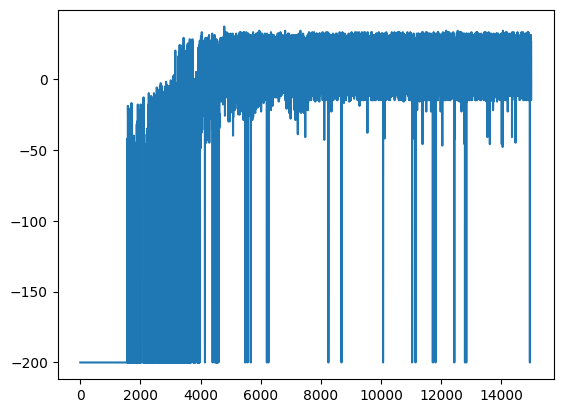

In [14]:
# let's see the rewards progression
plt.plot(rewards)
plt.show()

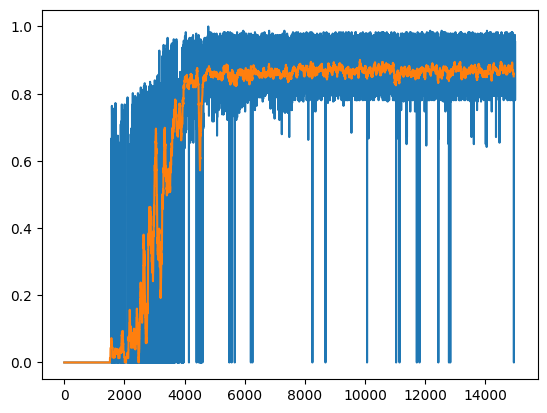

In [15]:
# convert the rewards -list into NumPy -array format
rewards_arr = np.array(rewards)

# define a window size for a moving average

# 50 is okay for 15000 episodes as the minimum window size
# if the running mean line is too noisy, adjust the window size
# rule of thumb: many episodes => bigger window_ize
# 15000 => 30-50 is okay for window size
window_size = 50

# normalize the rewards (manual MinMax -normalization)
normalized_rewards = (rewards_arr - min(rewards_arr)) / (max(rewards_arr) - min(rewards_arr))

# calculate the running mean
running_mean = np.convolve(normalized_rewards, np.ones(window_size) / window_size, mode="valid")

# visualize rewards + RUNNING MEAN
plt.plot(normalized_rewards)
plt.plot(running_mean)
plt.show()

#### We can't really see here how the agent learns, there's too much fluctuation

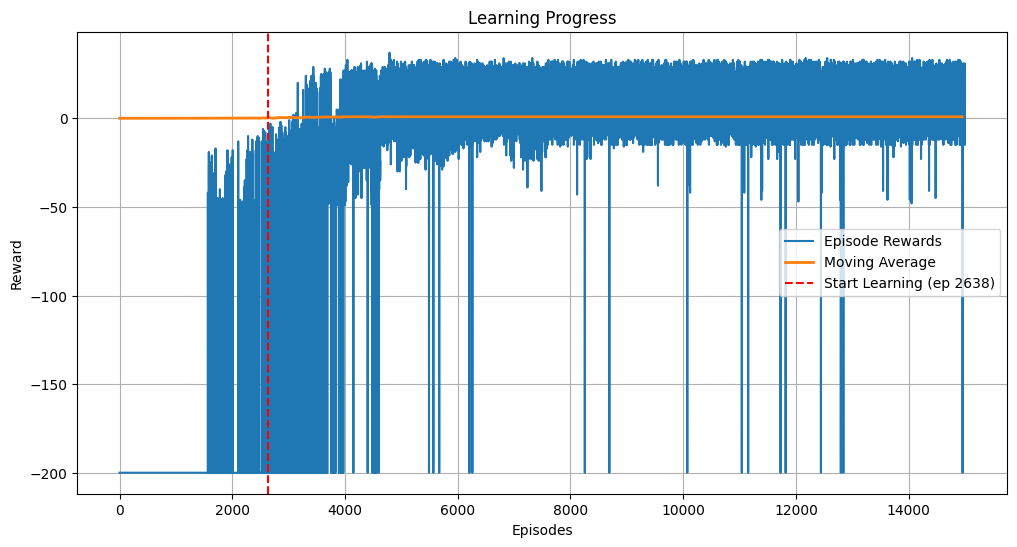

In [ ]:

#The agent initially explored randomly and received low rewards (mostly around -200). Over time, as it updated its Q-table and reduced exploration, it started improving its actions. By episode 2638, the moving average of the rewards consistently exceeded the threshold of -110, showing that the agent learned a strategy to reliably reach the goal. After this point, performance stabilized, indicating successful policy learning.


# convert the rewards -list into NumPy -array format
rewards_arr = np.array(rewards)

# define a window size for a moving average
window_size = 50

# normalize the rewards (manual MinMax -normalization)
normalized_rewards = (rewards_arr - min(rewards_arr)) / (max(rewards_arr) - min(rewards_arr))

# calculate the running mean
running_mean = np.convolve(normalized_rewards, np.ones(window_size) / window_size, mode="valid")

# detect when performance improves
threshold = -110
learning_episode = next((i for i in range(len(rewards)) if np.mean(rewards[i:i+50]) > threshold), None)

# visualize rewards + RUNNING MEAN + learning marker
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Episode Rewards')
plt.plot(running_mean, label='Moving Average', linewidth=2)

# Mark the episode where learning is noticeable
if learning_episode:
    plt.axvline(x=learning_episode, color='r', linestyle='--', label=f'Start Learning (ep {learning_episode})')

plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Learning Progress")
plt.legend()
plt.grid(True)
plt.show()


## Let's allow the agent to play the game now

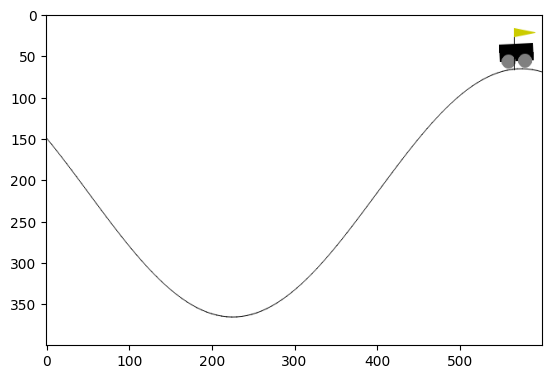

Episode: 3 done with total_rewards: -157.0


In [17]:
# let's use now the Q-table (agent) we have for this environment
# => play the game based on the Q-table but only using exploitation

total_test_episodes = 3

env.reset()
clear_output(wait=True)
plt.imshow(env.render())
plt.show()

# for-loop => allow the agent to play this 5 times in a row (5 episodes)
for episode in range(total_test_episodes):
    state, info = env.reset()
    state = get_state(state)
    done = False
    total_rewards = 0

    # play for the max number of steps
    for step in range(max_steps):
        # take the best action for this situation from the Q-table
        # basically based on the current cell => choose the best action we have calculated
        # in the Q-table during training

        # an idea for the exercise project:
        # => if multiple identical high values => choose a random path
        action = np.argmax(Q_table[state[0], state[1]])

        # unpack the results
        observation, reward, done, truncated, info = env.step(action)
        observation = get_state(observation)

        # update total rewards
        total_rewards = total_rewards + reward

        # update the visual frame
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()

        # if we are game over either by hole or goal => break the loop
        if done:
            print(f"Episode: {episode + 1} done with total_rewards: {total_rewards}")
            time.sleep(2)
            break

        # save new state as old state, continue with next step
        state = observation
        # time.sleep(0.3)

env.close()